### Get All Results

In [ ]:
import os
import pandas as pd
from glob import glob

fps = glob("trimmed_outputs/puzzles/**/*.json", recursive=True)

dfs = []

for fp in fps:
    df = pd.read_json(fp)

    parts = fp.split("/")
    data_version = parts[1]
    condition = parts[2]
    model_name = parts[-1].replace(".json", "")

    df.insert(0, "data_version", data_version)
    df.insert(1, "condition", condition)
    df.insert(2, "model_name", model_name)
    df = df[df.solution_count > 0]
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.shape

(19432, 12)

In [3]:
from src.eval.metrics import compute_metric_for_df
from src.eval.answer_extractors import rule_based_answer_extractor

combined_df["prediction"] = combined_df["response"].apply(rule_based_answer_extractor)
combined_df = compute_metric_for_df(combined_df)

metrics_cols = ["exact_match_accuracy", "precision", "recall", "f1", "jaccard_index"]
combined_df[metrics_cols] = (combined_df[metrics_cols] * 100).round(1)
combined_df.columns

Index(['data_version', 'condition', 'model_name', 'identifier', 'prompt',
       'constraints', 'solutions', 'solution_count', 'response',
       'input_tokens', 'output_tokens', 'total_tokens', 'prediction',
       'precision', 'recall', 'f1', 'jaccard_index', 'exact_match_accuracy'],
      dtype='object')

In [4]:
cols = [
    'condition', 'model_name', 'solution_count', 'f1',
       'jaccard_index', 'exact_match_accuracy'
]
model_renamer = {
    "gpt-5-2025-08-07": "GPT-5",
    "gpt-5-nano-2025-08-07": "GPT-5-nano",
    "gpt-4.1-2025-04-14": "GPT-4.1",
    "gpt-4.1-nano-2025-04-14": "GPT-4.1-nano",
    "gpt-oss-20b": "GPT-oss-20B",
    "deepseek-reasoner": "DeepSeek-V3.2-R",
    "deepseek-chat": "DeepSeek-V3.2",
    "Qwen3-4B-Instruct-2507": "Qwen3-4B-Inst",
    "Qwen3-4B-Thinking-2507": "Qwen3-4B-Think",
    "Qwen3-8B": "Qwen3-8B",
    "Qwen3-14B": "Qwen3-14B",
    "Ministral-3-8B-Instruct-2512": "Ministral-3-8B-Inst",
    "Ministral-3-8B-Reasoning-2512": "Ministral-3-8B-R"
}

constraint_mapper = {
    "no_tool_use_with_explicit_constraints": "Explicit",
    "no_tool_use": "Implicit",
    "with_pseudo_gpt_web_search_context_and_code_interpreter": "Implicit+Web+CI",
    "with_code_interpreter_with_explicit_constraints": "Explicit+CI",
    "with_code_interpreter": "Implicit+CI",
    "with_web_search": "Implicit+Web",
    "with_pseudo_gpt_web_search_contextgpt-4.1-2025-04-14": "Implicit+GPT-4.1 Web",
    "with_pseudo_gpt_web_search_contextgpt-5-2025-08-07": "Implicit+GPT-5 Web",
}

order_index = {m: i for i, m in enumerate(model_renamer.values())}
combined_df.condition = combined_df.condition.apply(lambda x: constraint_mapper.get(x, x))
combined_df["model_name"] = combined_df["model_name"].apply(lambda x: model_renamer.get(x, x))
combined_df = combined_df.sort_values(by="model_name", key=lambda s: s.map(order_index))
combined_df.head()

,data_version,condition,model_name,identifier,prompt,constraints,solutions,solution_count,response,input_tokens,output_tokens,total_tokens,prediction,precision,recall,f1,jaccard_index,exact_match_accuracy
16792,dec-26-2026-puzzles-2,Explicit+CI,GPT-5,65cbf5c6-b2e0-48f7-8809-73b2d7cafaa7,"From the time-related constraints below, deter...",- It is a Monday or Wednesday.\n- It is Decemb...,[1953-12-07],1,Reasoning:\n- Combine year=1953 and month=Dece...,3022,2636,5658,[1953-12-07],100.0,100.0,100.0,100.0,100.0
16760,dec-26-2026-puzzles-2,Explicit+CI,GPT-5,4783a31a-9acd-4a15-8c61-ff2f63d00017,"From the time-related constraints below, deter...",- It is a Saturday.\n- The date is between Jan...,[2023-08-26],1,Step-by-step:\n- Year must be 2023.\n- Month m...,1240,363,1603,[2023-08-26],100.0,100.0,100.0,100.0,100.0
16791,dec-26-2026-puzzles-2,Explicit+CI,GPT-5,daf1495f-72f1-4edb-85b3-a666dbdf4053,"From the time-related constraints below, deter...",- The year is 2017.\n- It is a Saturday or Sun...,[2017-04-29],1,Step-by-step reasoning:\n- Year must be 2017 a...,2746,1943,4689,[2017-04-29],100.0,100.0,100.0,100.0,100.0
16790,dec-26-2026-puzzles-2,Explicit+CI,GPT-5,265a3723-261c-4384-8cc8-35d5babfb41f,"From the time-related constraints below, deter...",- It is June.\n- The year is in the 1890s.\n- ...,[1893-06-11],1,Reasoning:\n- Constraints fix the year to 1893...,1236,398,1634,[1893-06-11],100.0,100.0,100.0,100.0,100.0
16789,dec-26-2026-puzzles-2,Explicit+CI,GPT-5,26d55967-440d-46ab-acaa-58aefccf707d,"From the time-related constraints below, deter...",- It is the 2nd Thursday of the month.\n- It i...,[1886-05-13],1,"- Fixed components: year 1886, month May, day ...",1731,747,2478,[1886-05-13],100.0,100.0,100.0,100.0,100.0


In [73]:
combined_df.columns

Index(['data_version', 'condition', 'model_name', 'identifier', 'prompt',
       'constraints', 'solutions', 'solution_count', 'response',
       'input_tokens', 'output_tokens', 'total_tokens', 'prediction',
       'precision', 'recall', 'f1', 'jaccard_index', 'exact_match_accuracy'],
      dtype='object')

In [111]:
len(combined_df.dropna())

19432

In [107]:
combined_df["EM Vs F1"] = combined_df["exact_match_accuracy"] - combined_df["f1"]
combined_df["EM Vs JI"] = combined_df["exact_match_accuracy"] - combined_df["jaccard_index"]
comp = combined_df[["EM Vs F1", "EM Vs JI"]].describe().round(2).T
comp[["mean", "std", "25%"]]

,mean,std,25%
EM Vs F1,-7.07,20.52,0.0
EM Vs JI,-5.40,16.41,0.0


In [117]:
(combined_df["EM Vs F1"] == 0).mean().round(4), (combined_df["EM Vs JI"] == 0).mean().round(4)

(np.float64(0.8798), np.float64(0.8798))

In [109]:
print(comp[["mean", "std", "25%"]].to_latex(float_format="%.2f") )

\begin{tabular}{lrrr}
\toprule
 & mean & std & 25% \\
\midrule
EM Vs F1 & -7.07 & 20.52 & 0.00 \\
EM Vs JI & -5.40 & 16.41 & 0.00 \\
\bottomrule
\end{tabular}



In [110]:
crr = combined_df[['f1', 'jaccard_index', 'exact_match_accuracy']].corr("spearman")
crr.round(2)

,f1,jaccard_index,exact_match_accuracy
f1,1.00,1.00,0.92
jaccard_index,1.00,1.00,0.92
exact_match_accuracy,0.92,0.92,1.00


In [106]:
crr = combined_df[['f1', 'jaccard_index', 'exact_match_accuracy']].corr("pearson")
crr

,f1,jaccard_index,exact_match_accuracy
f1,1.000000,0.995025,0.905081
jaccard_index,0.995025,1.000000,0.938920
exact_match_accuracy,0.905081,0.938920,1.000000


In [105]:
crr = combined_df[['f1', 'jaccard_index', 'exact_match_accuracy']].corr("kendall")
crr

,f1,jaccard_index,exact_match_accuracy
f1,1.000000,1.000000,0.871028
jaccard_index,1.000000,1.000000,0.871028
exact_match_accuracy,0.871028,0.871028,1.000000


In [5]:
# sanity check

t = combined_df.groupby(["model_name", "condition"]).size().unstack(fill_value=0)
print(t.sum().sum())
t

19432


condition,Explicit,Explicit+CI,Implicit,Implicit+CI,Implicit+GPT-4.1 Web,Implicit+GPT-5 Web,Implicit+Web,Implicit+Web+CI,with_pseudo_gpt_web_search_context
model_name,,,,,,,,,
DeepSeek-V3.2,600,0,600,0,0,0,0,0,0
DeepSeek-V3.2-R,600,0,600,0,296,291,0,0,0
GPT-4.1,600,100,600,100,0,0,300,98,0
GPT-4.1-nano,600,0,600,0,0,0,0,0,0
GPT-5,600,100,600,100,0,0,300,99,0
GPT-5-nano,600,2,600,0,0,0,0,0,0
GPT-oss-20B,600,0,600,0,296,288,0,0,296
Ministral-3-8B-Inst,600,0,600,0,0,0,0,0,0
Ministral-3-8B-R,600,0,600,0,296,287,0,0,0


In [6]:
# input output tokens analysis across models and conditions
combined_df.groupby(["model_name", "condition"])[["input_tokens", "output_tokens"]].median()

input_tokens  \
model_name          condition                                          
DeepSeek-V3.2       Explicit                                   229.0   
                    Implicit                                   243.0   
DeepSeek-V3.2-R     Explicit                                   229.0   
                    Implicit                                   243.0   
                    Implicit+GPT-4.1 Web                      7166.5   
                    Implicit+GPT-5 Web                        8765.0   
GPT-4.1             Explicit                                   232.0   
                    Explicit+CI                                735.5   
                    Implicit                                   246.0   
                    Implicit+CI                                887.5   
                    Implicit+Web                             31751.0   
                    Implicit+Web+CI                           6832.0   
GPT-4.1-nano        Explicit                                   232.0   
                    Implicit                                   246.0   
GPT-5               Explicit                                   231.0   
                    Explicit+CI                               1841.5   
                    Implicit                                   245.0   
                    Implicit+CI                               3147.0   
                    Implicit+Web                             25769.0   
                    Implicit+Web+CI                          10162.0   
GPT-5-nano          Explicit                                   231.0   
                    Explicit+CI                               4747.0   
                    Implicit                                   245.0   
GPT-oss-20B         Explicit                                   292.0   
                    Implicit                                   306.0   
                    Implicit+GPT-4.1 Web                      7121.5   
                    Implicit+GPT-5 Web                        8439.5   
                    with_pseudo_gpt_web_search_context        7121.5   
Ministral-3-8B-Inst Explicit                                   237.0   
                    Implicit                                   247.0   
Ministral-3-8B-R    Explicit                                   237.0   
                    Implicit                                   247.0   
                    Implicit+GPT-4.1 Web                      7865.5   
                    Implicit+GPT-5 Web                        9843.0   
Qwen3-14B           Explicit                                   239.0   
                    Implicit                                   250.0   
                    Implicit+GPT-4.1 Web                      8167.5   
                    Implicit+GPT-5 Web                        9992.0   
Qwen3-4B-Inst       Explicit                                   239.0   
                    Implicit                                   250.0   
Qwen3-4B-Think      Explicit                                   241.0   
                    Implicit                                   252.0   
Qwen3-8B            Explicit                                   239.0   
                    Implicit                                   250.0   

                                                        output_tokens  
model_name          condition                                          
DeepSeek-V3.2       Explicit                                    626.5  
                    Implicit                                    671.5  
DeepSeek-V3.2-R     Explicit                                   4461.5  
                    Implicit                                   7511.0  
                    Implicit+GPT-4.1 Web                       3933.0  
                    Implicit+GPT-5 Web                         3806.0  
GPT-4.1             Explicit                                    535.0  
                    Explicit+CI                                 436.5  
                    Imp

## Tool-less Results

In [7]:
tool_less_conditions = ["Implicit", "Explicit"]
tool_less_df = combined_df[combined_df.condition.isin(tool_less_conditions)]
tool_less_df.groupby(["condition"])["model_name"].value_counts()

condition  model_name         
Explicit   DeepSeek-V3.2          600
           DeepSeek-V3.2-R        600
           GPT-4.1                600
           GPT-4.1-nano           600
           GPT-5                  600
           GPT-5-nano             600
           GPT-oss-20B            600
           Ministral-3-8B-Inst    600
           Ministral-3-8B-R       600
           Qwen3-14B              600
           Qwen3-4B-Inst          600
           Qwen3-4B-Think         600
           Qwen3-8B               600
Implicit   DeepSeek-V3.2          600
           DeepSeek-V3.2-R        600
           GPT-4.1                600
           GPT-4.1-nano           600
           GPT-5                  600
           GPT-5-nano             600
           GPT-oss-20B            600
           Ministral-3-8B-Inst    600
           Ministral-3-8B-R       600
           Qwen3-14B              600
           Qwen3-4B-Inst          600
           Qwen3-4B-Think         600
           Qwen3-8B

In [8]:
metrics_cols = ['exact_match_accuracy', "output_tokens"]
tool_less_res_overall = tool_less_df.groupby(["condition", "model_name"])[metrics_cols].mean()
tool_less_res_overall

exact_match_accuracy  output_tokens
condition model_name                                              
Explicit  DeepSeek-V3.2                   68.500000     704.561667
          DeepSeek-V3.2-R                 77.000000    5821.751667
          GPT-4.1                         58.833333     593.001667
          GPT-4.1-nano                    40.000000    1023.638333
          GPT-5                           80.666667    3416.941667
          GPT-5-nano                      57.166667    4903.923333
          GPT-oss-20B                     43.833333    4965.181667
          Ministral-3-8B-Inst             12.333333    1650.460000
          Ministral-3-8B-R                18.666667    1749.406667
          Qwen3-14B                       46.500000    4782.318333
          Qwen3-4B-Inst                   21.166667    2563.528333
          Qwen3-4B-Think                  38.666667   10037.286667
          Qwen3-8B                        42.666667    7161.386667
Implicit  DeepSeek-V3.2                   27.000000     785.426667
          DeepSeek-V3.2-R                 33.333333    8276.541667
          GPT-4.1                         30.000000     671.580000
          GPT-4.1-nano                     8.166667    1116.870000
          GPT-5                           49.333333    4382.421667
          GPT-5-nano                      14.000000    5271.003333
          GPT-oss-20B                     10.166667    5600.955000
          Ministral-3-8B-Inst              3.666667    1801.041667
          Ministral-3-8B-R                 3.833333    2117.650000
          Qwen3-14B                       11.333333    4879.908333
          Qwen3-4B-Inst                    2.666667    2620.965000
          Qwen3-4B-Think                   5.500000    9529.893333
          Qwen3-8B                        10.000000    7603.551667

In [9]:
conditions = ["Implicit", "Explicit"]
models = list(model_renamer.values())

indices = pd.MultiIndex.from_product([conditions, models])

if "exact_match_accuracy" in tool_less_res_overall.columns and tool_less_res_overall["exact_match_accuracy"].max() <= 1.0:
    tool_less_res_overall["exact_match_accuracy"] = (tool_less_res_overall["exact_match_accuracy"] * 100).round(1)


tool_less_res_piv = tool_less_res_overall.pivot_table(
    index="model_name",
    columns="condition",
    values=["exact_match_accuracy", 
            "output_tokens"],
    aggfunc="mean"
).loc[model_renamer.values()].round(1)

cols = pd.MultiIndex.from_product([
    ["exact_match_accuracy", "output_tokens"],
    ["Implicit", "Explicit"]
])

tool_less_res_piv[cols]

exact_match_accuracy          output_tokens         
condition                       Implicit Explicit      Implicit Explicit
model_name                                                              
GPT-5                               49.3     80.7        4382.4   3416.9
GPT-5-nano                          14.0     57.2        5271.0   4903.9
GPT-4.1                             30.0     58.8         671.6    593.0
GPT-4.1-nano                         8.2     40.0        1116.9   1023.6
GPT-oss-20B                         10.2     43.8        5601.0   4965.2
DeepSeek-V3.2-R                     33.3     77.0        8276.5   5821.8
DeepSeek-V3.2                       27.0     68.5         785.4    704.6
Qwen3-4B-Inst                        2.7     21.2        2621.0   2563.5
Qwen3-4B-Think                       5.5     38.7        9529.9  10037.3
Qwen3-8B                            10.0     42.7        7603.6   7161.4
Qwen3-14B                           11.3     46.5        4879.9   4782.3
Ministral-3-8B-Inst                  3.7     12.3        1801.0   1650.5
Ministral-3-8B-R                     3.8     18.7        2117.6   1749.4

In [10]:
import pandas as pd

def res_piv_to_acl_latex(
    res_piv: pd.DataFrame,
    caption: str = (
        "Overall model performance averaged over solution counts. "),
    label: str = "tab:tool_less_overall_results",
    float_fmt_em: str = "{:.1f}",
    float_fmt_tok: str = "{:.1f}",
) -> str:
    """
    Convert res_piv into an ACL-style LaTeX table.

    Color semantics (consistent):
      - Green  -> increase
      - Red    -> decrease

    Annotations:
      - Exact Match: delta shown after Explicit
      - Output Tokens: delta shown after Explicit
    """

    # ---------- helpers ----------
    def find_col(metric_keys, cond_keys):
        for m in metric_keys:
            for c in cond_keys:
                if (m, c) in res_piv.columns:
                    return (m, c)
        return None

    em_def = find_col(
        ["exact_match_accuracy", "exact_match", "em"],
        ["Implicit", "Implicit"]
    )
    em_exp = find_col(
        ["exact_match_accuracy", "exact_match", "em"],
        ["Explicit", "Explicit"]
    )
    tok_def = find_col(
        ["output_tokens", "tokens"],
        ["Implicit", "Implicit"]
    )
    tok_exp = find_col(
        ["output_tokens", "tokens"],
        ["Explicit", "Explicit"]
    )

    if None in (em_def, em_exp, tok_def, tok_exp):
        raise ValueError(f"Unexpected columns: {res_piv.columns}")

    df = res_piv.copy().astype(float)

    em_delta = (df[em_exp] - df[em_def]).round(1)
    tok_delta = (df[tok_exp] - df[tok_def]).round(1)

    def fmt(x, f):
        return "" if pd.isna(x) else f.format(x)

    def delta_tex(d):
        if pd.isna(d) or d == 0:
            return ""
        color = "emgreen" if d > 0 else "tokred"
        sign = "+" if d > 0 else ""
        return rf"{{\tiny\textcolor{{{color}}}{{~({sign}{fmt(d, '{:.1f}')})}}}}"

    # ---------- rows ----------
    rows = []
    for model, r in df.iterrows():
        model = str(model).replace("_", r"\_")
        rows.append(
            f"{model} & "
            f"{fmt(r[em_def], float_fmt_em)} & "
            f"{fmt(r[em_exp], float_fmt_em)}{delta_tex(em_delta.loc[model.replace(r'\_', '_')])} & "
            f"{fmt(r[tok_def], float_fmt_tok)} & "
            f"{fmt(r[tok_exp], float_fmt_tok)}{delta_tex(tok_delta.loc[model.replace(r'\_', '_')])} \\\\"
        )

    # ---------- LaTeX ----------
    preamble = r"""
% Required in preamble:
% \usepackage{booktabs}
% \usepackage{xcolor}
\definecolor{emgreen}{RGB}{0,120,60}
\definecolor{tokred}{RGB}{160,60,60}
""".strip()

    table = r"""
\begin{table}[t]
\centering
\scriptsize
\setlength{\tabcolsep}{4.5pt}
\renewcommand{\arraystretch}{1.08}
\begin{tabular}{lrrrr}
\toprule
& \multicolumn{2}{c}{\textbf{Exact Match} (\%)} & \multicolumn{2}{c}{\textbf{Output Tokens}} \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}
& Default & Explicit & Default & Explicit \\
\midrule
""" + "\n".join(rows) + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
""".strip()

    return preamble + "\n\n" + table

In [11]:
latex_str = res_piv_to_acl_latex(tool_less_res_piv[cols])
print(latex_str)

% Required in preamble:
% \usepackage{booktabs}
% \usepackage{xcolor}
\definecolor{emgreen}{RGB}{0,120,60}
\definecolor{tokred}{RGB}{160,60,60}


\begin{table}[t]
\centering
\scriptsize
\setlength{\tabcolsep}{4.5pt}
\renewcommand{\arraystretch}{1.08}
\begin{tabular}{lrrrr}
\toprule
& \multicolumn{2}{c}{\textbf{Exact Match} (\%)} & \multicolumn{2}{c}{\textbf{Output Tokens}} \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}
& Default & Explicit & Default & Explicit \\
\midrule
GPT-5 & 49.3 & 80.7{\tiny\textcolor{emgreen}{~(+31.4)}} & 4382.4 & 3416.9{\tiny\textcolor{tokred}{~(-965.5)}} \\
GPT-5-nano & 14.0 & 57.2{\tiny\textcolor{emgreen}{~(+43.2)}} & 5271.0 & 4903.9{\tiny\textcolor{tokred}{~(-367.1)}} \\
GPT-4.1 & 30.0 & 58.8{\tiny\textcolor{emgreen}{~(+28.8)}} & 671.6 & 593.0{\tiny\textcolor{tokred}{~(-78.6)}} \\
GPT-4.1-nano & 8.2 & 40.0{\tiny\textcolor{emgreen}{~(+31.8)}} & 1116.9 & 1023.6{\tiny\textcolor{tokred}{~(-93.3)}} \\
GPT-oss-20B & 10.2 & 43.8{\tiny\textcolor{emgreen}{~(+33.6)}} & 5601.

### Examine Web Search

In [12]:
combined_df.condition.unique()

array(['Explicit+CI', 'Implicit', 'Implicit+Web+CI', 'Implicit+Web',
       'Explicit', 'Implicit+CI', 'Implicit+GPT-4.1 Web',
       'Implicit+GPT-5 Web', 'with_pseudo_gpt_web_search_context'],
      dtype=object)

In [13]:
web_search_conditions = ["Implicit", "Explicit", "Implicit+Web", "Implicit+GPT-4.1 Web", "Implicit+GPT-5 Web"]
web_search_models = ["GPT-5", "GPT-4.1", "GPT-oss-20B", 
                     "DeepSeek-V3.2-R", "Qwen3-14B", "Ministral-3-8B-R"]
web_search_df = combined_df[(combined_df.condition.isin(web_search_conditions)) & 
                            (combined_df.model_name.isin(web_search_models))]
web_search_res_overall = web_search_df.groupby(["condition", "model_name"])[metrics_cols].mean()
web_search_res_overall

exact_match_accuracy  output_tokens
condition            model_name                                           
Explicit             DeepSeek-V3.2-R              77.000000    5821.751667
                     GPT-4.1                      58.833333     593.001667
                     GPT-5                        80.666667    3416.941667
                     GPT-oss-20B                  43.833333    4965.181667
                     Ministral-3-8B-R             18.666667    1749.406667
                     Qwen3-14B                    46.500000    4782.318333
Implicit             DeepSeek-V3.2-R              33.333333    8276.541667
                     GPT-4.1                      30.000000     671.580000
                     GPT-5                        49.333333    4382.421667
                     GPT-oss-20B                  10.166667    5600.955000
                     Ministral-3-8B-R              3.833333    2117.650000
                     Qwen3-14B                    11.333333    4879.908333
Implicit+GPT-4.1 Web DeepSeek-V3.2-R              57.770270    5301.429054
                     GPT-oss-20B                  35.810811    3270.695946
                     Ministral-3-8B-R             15.540541    1214.929054
                     Qwen3-14B                    39.864865    2638.770270
Implicit+GPT-5 Web   DeepSeek-V3.2-R              57.388316    5570.096220
                     GPT-oss-20B                  38.194444    3656.805556
                     Ministral-3-8B-R             17.421603    1089.599303
                     Qwen3-14B                    44.947735    2643.459930
Implicit+Web         GPT-4.1                      42.666667     638.743333
                     GPT-5                        69.333333    3763.233333

In [18]:
from src.eval.visualizations import plot_trend_grid_by_model

In [30]:
condition_order = [
    "Implicit",
    "Explicit",
    "Implicit+Web",
    "Implicit+GPT-4.1 Web",
    "Implicit+GPT-5 Web",
    "Implicit+CI",
    "Explicit+CI",
    "Implicit+Web+CI",
]

condition_colors = {
    "Implicit":           "#1f77b4", 
    "Explicit":           "#ff7f0e",
    "Implicit+Web":       "#2ca02c",  
    "Implicit+GPT-4.1 Web":        "#d62728", 
    "Implicit+GPT-5 Web":          "#9467bd", 
    "Implicit+CI":        "#8c564b",  
    "Explicit+CI":        "#e377c2", 
    "Implicit+Web+CI":    "#7f7f7f",  
}

condition_colors_sub = {
    "Implicit":           "#1f77b4", 
    "Explicit":           "#ff7f0e",
    "Implicit+Web":       "#2ca02c",  
    "Implicit+GPT-4.1 Web":        "#d62728", 
    "Implicit+GPT-5 Web":          "#9467bd", 
}

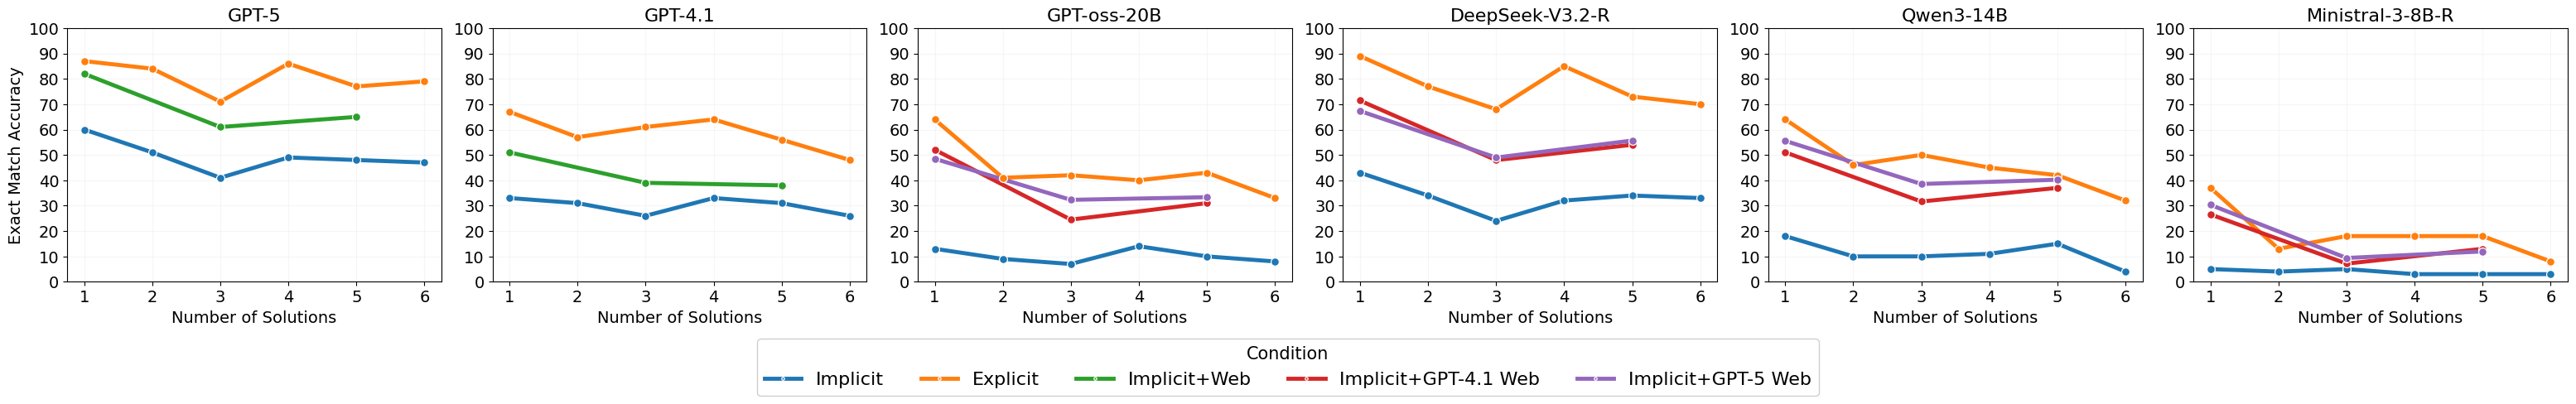

In [72]:
fig, axes = plot_trend_grid_by_model(
    web_search_df,
    nrows=1,
    y_col="exact_match_accuracy",
    sharey=False,
    condition_order=list(condition_colors_sub.keys()),
    condition_colors=condition_colors_sub,
    legend_y=-0.075,
    mean_lw=3.5,
    mean_marker_min_size=50,
    figsize_per_subplot=(5.2, 4.6),
    save_fp="figures/em_across_solution_counts.pdf",
    legend_fontsize=16,
)

fig.show()

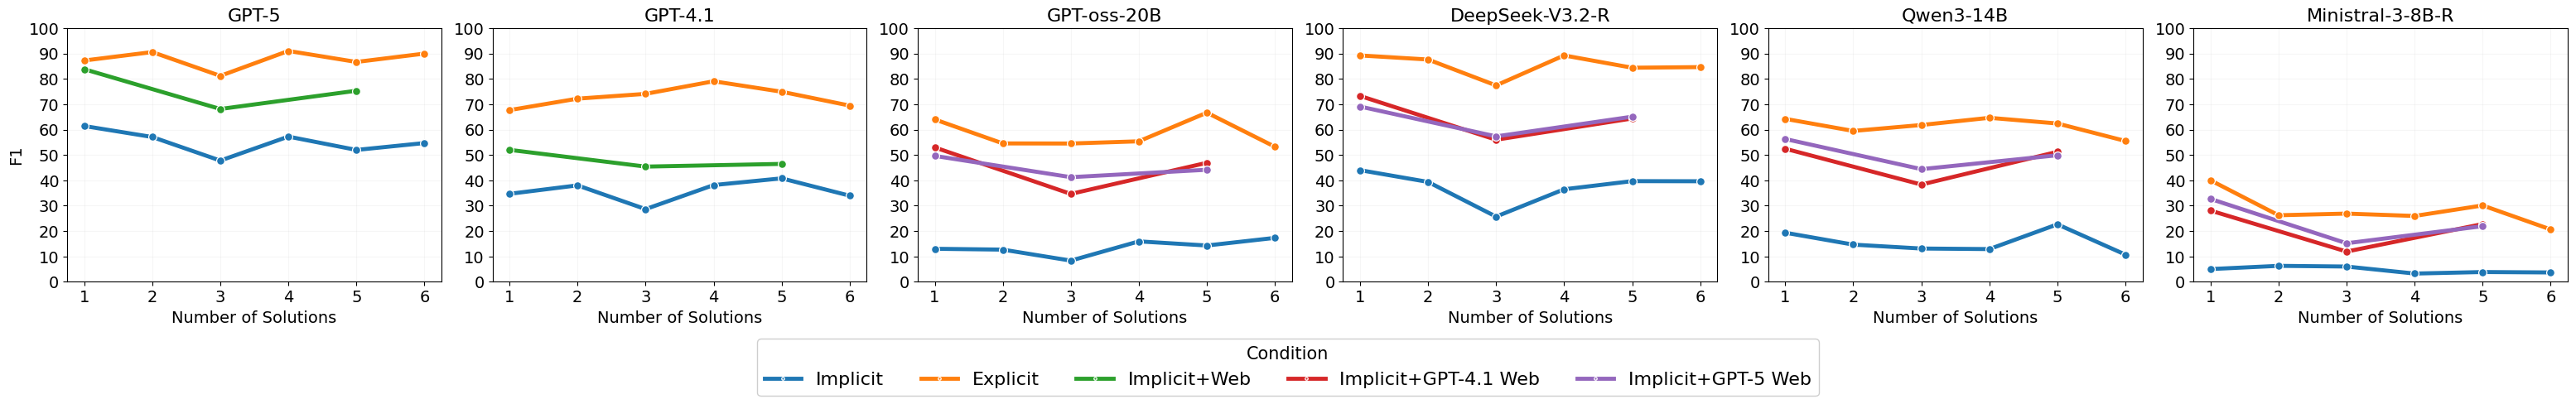

In [119]:
fig, axes = plot_trend_grid_by_model(
    web_search_df,
    nrows=1,
    y_col="f1",
    sharey=False,
    condition_order=list(condition_colors_sub.keys()),
    condition_colors=condition_colors_sub,
    legend_y=-0.075,
    mean_lw=3.5,
    mean_marker_min_size=50,
    figsize_per_subplot=(5.2, 4.6),
    save_fp="figures/f1_across_solution_counts.pdf",
    legend_fontsize=16,
)

fig.show()

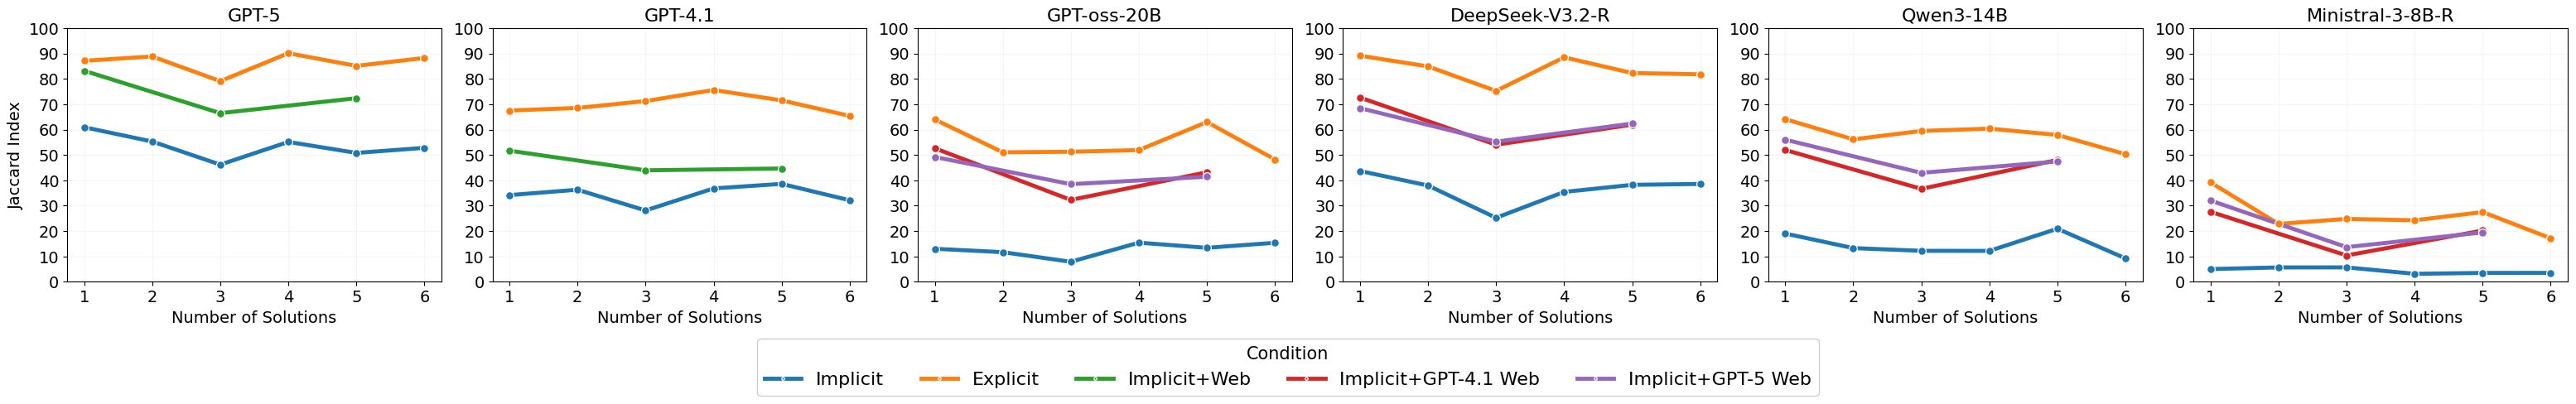

In [120]:
fig, axes = plot_trend_grid_by_model(
    web_search_df,
    nrows=1,
    y_col="jaccard_index",
    sharey=False,
    condition_order=list(condition_colors_sub.keys()),
    condition_colors=condition_colors_sub,
    legend_y=-0.075,
    mean_lw=3.5,
    mean_marker_min_size=50,
    figsize_per_subplot=(5.2, 4.6),
    save_fp="figures/jaccard_index_across_solution_counts.pdf",
    legend_fontsize=16,
)

fig.show()

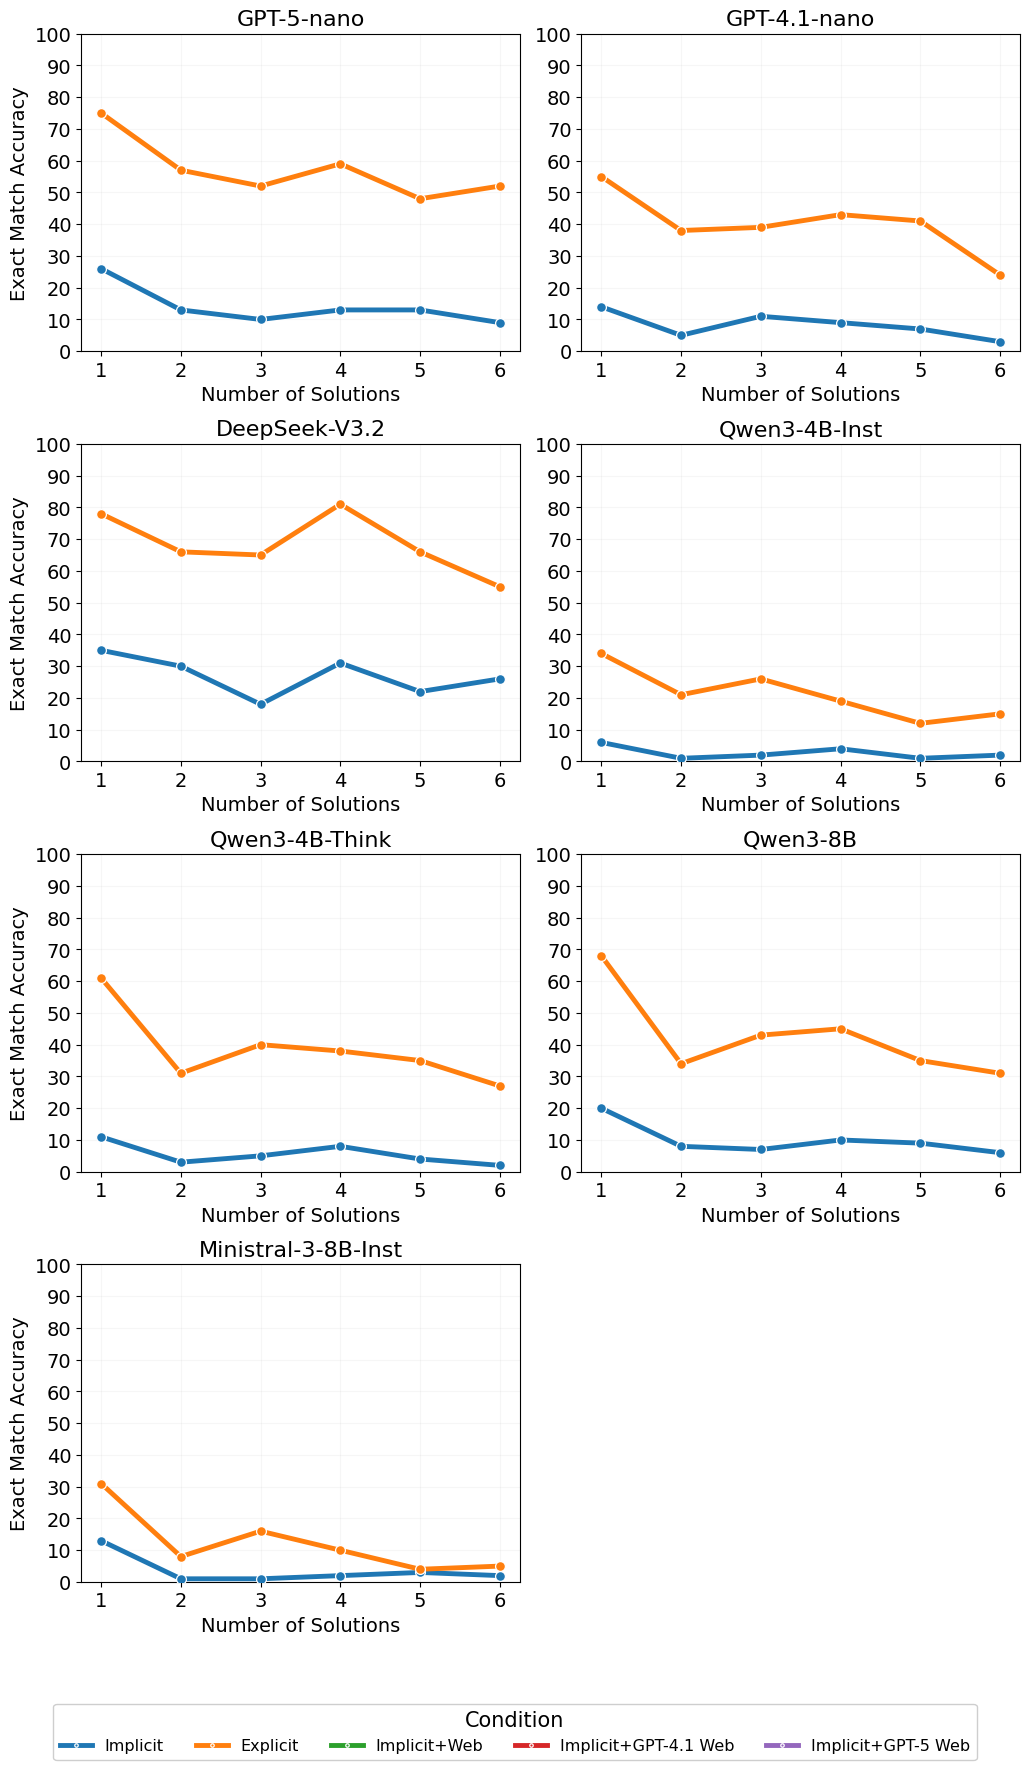

In [130]:
from src.eval.visualizations import plot_trend_grid_by_model

fig, axes = plot_trend_grid_by_model(
    tool_less_df[~tool_less_df.model_name.isin(web_search_models)],
    nrows=4,
    y_col="exact_match_accuracy",
    sharey=False,
    condition_order=list(condition_colors_sub.keys()),
    condition_colors=condition_colors_sub,
    legend_y=0.075,
    mean_lw=3.5,
    mean_marker_min_size=50,
    figsize_per_subplot=(5.2, 4.6),
    save_fp="figures/em_across_solution_counts_other_models.pdf",
    legend_fontsize=11.5,
    legend_loc="upper center",
)
fig.show()

### Code Interpreter

In [79]:
combined_df.condition.unique()

array(['Explicit+CI', 'Implicit', 'Implicit+Web+CI', 'Implicit+Web',
       'Explicit', 'Implicit+CI', 'Implicit+GPT-4.1 Web',
       'Implicit+GPT-5 Web', 'with_pseudo_gpt_web_search_context'],
      dtype=object)

In [80]:
solution_count = 1
code_interpreter_models = ["GPT-5", "GPT-4.1"]
code_interpreter_conditions = ["Implicit", "Explicit", 'Implicit+Web', 
                               "Implicit+CI", "Explicit+CI", "Implicit+Web+CI"]
code_interpreter_df = combined_df[
    (combined_df.solution_count == solution_count) &
    (combined_df.model_name.isin(code_interpreter_models)) &
    (combined_df.condition.isin(code_interpreter_conditions))
]
code_interpreter_df.value_counts(["condition", "model_name"])

condition        model_name
Explicit         GPT-4.1       100
                 GPT-5         100
Explicit+CI      GPT-4.1       100
                 GPT-5         100
Implicit         GPT-4.1       100
                 GPT-5         100
Implicit+CI      GPT-4.1       100
                 GPT-5         100
Implicit+Web     GPT-4.1       100
                 GPT-5         100
Implicit+Web+CI  GPT-5          99
                 GPT-4.1        98
Name: count, dtype: int64

In [81]:
indices = pd.MultiIndex.from_product([code_interpreter_models, code_interpreter_conditions])
code_interpreter_df.groupby(["model_name", "condition"])[metrics_cols].mean().round(1).loc[indices]

exact_match_accuracy  output_tokens
model_name condition                                           
GPT-5      Implicit                         60.0         3849.2
           Explicit                         87.0         2547.8
           Implicit+Web                     82.0         3206.8
           Implicit+CI                      57.0         3499.5
           Explicit+CI                      87.0         2177.4
           Implicit+Web+CI                  77.8         1779.1
GPT-4.1    Implicit                         33.0          567.0
           Explicit                         67.0          464.9
           Implicit+Web                     51.0          580.7
           Implicit+CI                      38.0          657.3
           Explicit+CI                      66.0          510.1
           Implicit+Web+CI                  60.2          547.2

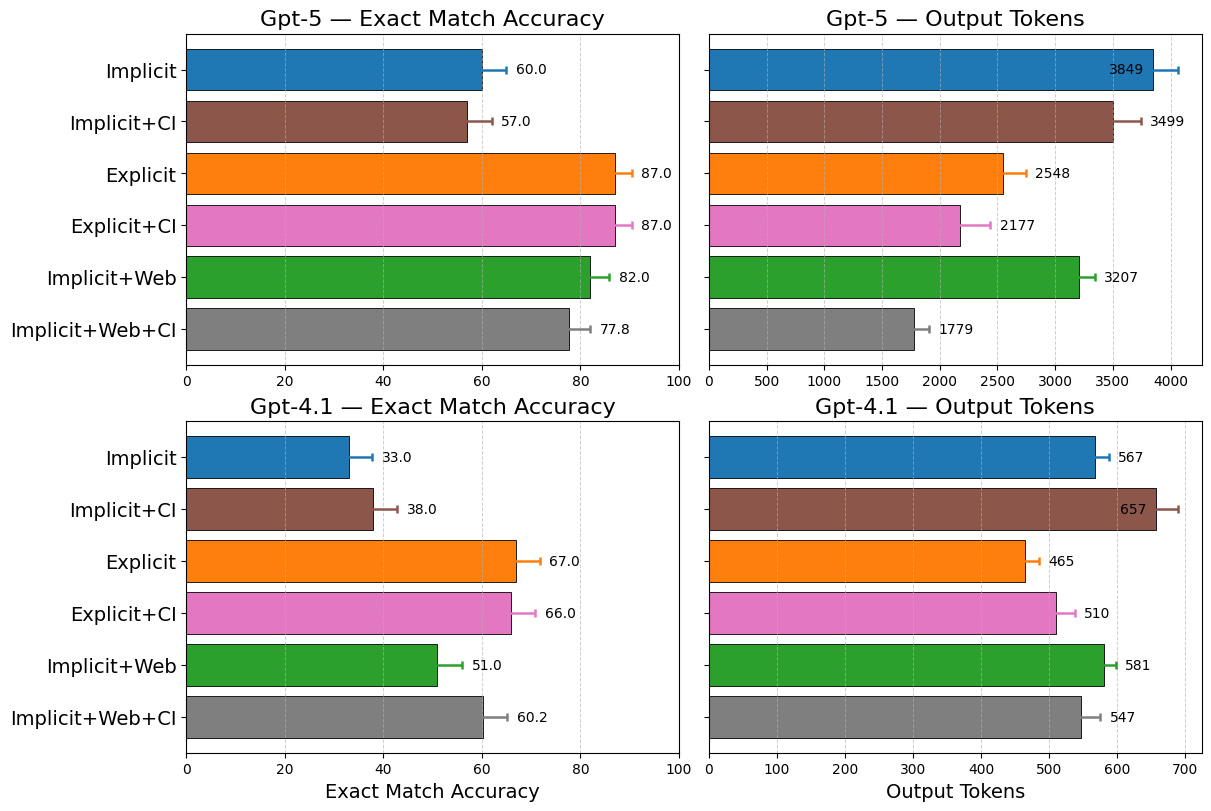

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Assumes RAW rows in code_interpreter_df (not already aggregated)
# Columns needed: model_name, condition, exact_match_accuracy, output_tokens
# Error bars: SEM = std / sqrt(n)  (swap to std if you prefer)
# =========================

metrics = ["exact_match_accuracy", "output_tokens"]
model_order = ["GPT-5", "GPT-4.1"]
condition_order = [
    "Implicit",
    "Implicit+CI",
    "Explicit",
    "Explicit+CI",
    "Implicit+Web",
    "Implicit+Web+CI",
][::-1]

def sem(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = len(x)
    if n <= 1:
        return np.nan
    return x.std(ddof=1) / np.sqrt(n)

# ---- Aggregate: mean + SEM ----
agg = (
    code_interpreter_df
    .groupby(["model_name", "condition"])[metrics]
    .agg(["mean", sem, "count"])
)
agg.columns = [f"{m}_{stat}" for m, stat in agg.columns]
summary_df = agg.reset_index()

# ---- Enforce ordering exactly ----
summary_df["model_name"] = pd.Categorical(summary_df["model_name"], categories=model_order, ordered=True)
summary_df["condition"]  = pd.Categorical(summary_df["condition"],  categories=condition_order, ordered=True)
summary_df = summary_df.sort_values(["model_name", "condition"])

# ---- Color map: consistent color per condition across all panels ----
cmap = plt.get_cmap("Set2")  # alternatives: "tab10", "tab20", "Paired"
cond2color = {
    cond: cmap(i / max(1, len(condition_order) - 1))
    for i, cond in enumerate(condition_order)
}
cond2color = condition_colors


def plot_panel(ax, df_m, metric, title, xlim=None, 
               fmt="{:.1f}", force_int=False):
    # Reindex to ensure exact condition ordering (and drop missing)
    df_m = df_m.set_index("condition").reindex(condition_order).dropna(subset=[f"{metric}_mean"]).reset_index()

    conds = df_m["condition"].astype(str).tolist()
    means = df_m[f"{metric}_mean"].to_numpy()
    errs  = df_m[f"{metric}_sem"].to_numpy()
    colors = [cond2color[c] for c in conds]

    y = np.arange(len(conds))

    # Bars (no xerr here; we draw error bars manually so each can match bar color)
    bars = ax.barh(
        y, means,
        color=colors,
        edgecolor="black",
        linewidth=0.6,
    )

    ax.set_yticks(y, labels=conds, fontsize=14)
    ax.set_title(title, fontsize=16)

    if model != "GPT-5":
        ax.set_xlabel(metric.replace("_", " ").title(), fontsize=14)
    # ax.set_ylabel("Condition", fontsize=14)
    ax.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.6)
    ax.invert_yaxis()

    if xlim is not None:
        ax.set_xlim(*xlim)

    xmin, xmax = ax.get_xlim()
    span = xmax - xmin
    pad = 0.02 * span  # padding between errorbar and text

    # Per-bar colored errorbars + labels that do NOT overlap error bars
    for i, (m, e, col) in enumerate(zip(means, errs, colors)):
        # error bar (same color as bar)
        if np.isfinite(e) and e > 0:
            ax.errorbar(
                x=m, y=i, xerr=e,
                fmt="none",
                ecolor=col,
                elinewidth=1.8,
                capsize=3,
                capthick=1.8,
                zorder=3,
            )
            text_x = m + e + pad  # put label after the errorbar tip
        else:
            text_x = m + pad

        # label formatting
        if force_int:
            label = f"{int(round(m))}"
        else:
            label = fmt.format(m)

        # if label would go out of bounds, put it inside the bar near the end
        ha = "left"
        if text_x > xmax - 0.005 * span:
            text_x = m - pad
            ha = "right"

        ax.text(
            text_x, i, label,
            va="center", ha=ha, fontsize=10
        )

# ---- Plot 2x2 ----
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    sharey="row", constrained_layout=True
)

for r, model in enumerate(model_order):
    df_m = summary_df[summary_df["model_name"] == model].copy()

    # Accuracy (0–100)
    plot_panel(
        axes[r, 0], df_m,
        metric="exact_match_accuracy",
        title=f"{model} — exact match accuracy".title(),
        xlim=(0, 100),
        fmt="{:.1f}",
        force_int=False,
    )

    # Tokens (auto limits)
    plot_panel(
        axes[r, 1], df_m,
        metric="output_tokens",
        title=f"{model} — output tokens".title(),
        xlim=None,
        fmt="{:.0f}"
    )

plt.savefig(
    "figures/code_interpreter_conditions_comparison.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()